<a href="https://colab.research.google.com/github/onni-Q/workshop_notebooks/blob/main/Week4_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important**: Before you run any cells in this notebooks, in the top menu go to **Runtime|Change runtime type** and switch your runtime to **Python 3** with hardware accelerator **T4 GPU**.

When asked, please **allow the notebook access to Google drive**.

Please run the cell below to set up the environment. This take a little while.


**This workshop consists of three parts. The first part covers hate-speech detection and fine-tuning Transformers. The second part 'Case Study: Text Classification Patents' is about patents and text-to-text Transformers, which are the reason why people are now using LLMs also for things like sentiment analysis. The third part 'A Tour of Transformers Applications' is a run through other so-called zero shot applications with Transformers. To get a complete, please complete 2 of the 3 parts.**


In [156]:
# Keep cell
# Running this takes a while!
%%capture

import sys
import os
import nltk

import matplotlib.pyplot as plt
import torch
import transformers

import pandas as pd
import numpy as np

try:
  import learntools.core
  from learntools.core import binder
  binder.bind(globals())
except:
  !pip install git+https://github.com/Kaggle/learntools.git
  import learntools.core
  from learntools.core import binder
  binder.bind(globals())

if not(os.path.exists('text_workshop_tests.py')):
  print('Downloading text_workshop_tests.py\n')
  !wget https://raw.githubusercontent.com/goto4711/cdai/refs/heads/main/text_workshop_tests.py


from text_workshop_tests import *


#Load models ...

#from google.colab import drive
#drive.mount('/content/drive')
#CACHE_DIR = "/content/drive/MyDrive/CDA-CACHE/huggingface"
#os.makedirs(CACHE_DIR, exist_ok=True) # Create the folder if it doesn't exist
#os.environ['HF_HOME'] = CACHE_DIR
# Alternatively, for older transformers versions: os.environ['TRANSFORMERS_CACHE'] = CACHE_DIR
#os.environ['TRANSFORMERS_CACHE'] = CACHE_DIR
#print(f"Hugging Face cache directory set to: {os.environ.get('HF_HOME')}")

try:
  import datasets
except:
  !pip install datasets
  import datasets

try:
  import huggingface_hub
except:
  !pip install huggingface_hub
  import huggingface_hub

try:
  import accelerate
except:
  !pip install accelerate
  import accelerate

try:
  import opendatasets
except:
  !pip install opendatasets
  import opendatasets

try:
  import sacremoses
except:
  !pip install sacremoses
  import sacremoses

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')
  nltk.download('punkt_tab')

try:
  nltk.data.find('corpora/stopwords')
except LookupError:
  nltk.download('stopwords')


if not(os.path.exists('TwitterHate_Small.csv')):
  print('Downloading TwitterHate_Small.csv')
  !wget https://raw.githubusercontent.com/goto4711/cdai/main/TwitterHate_Small.csv

if not(os.path.exists('uspppm-data')):
  print('Downloading usppm-data\n')
  !wget https://github.com/goto4711/cdai/raw/main/uspppm-data.zip
  !unzip -q uspppm-data.zip
  !rm uspppm-data.zip


is_colab = "google.colab" in sys.modules
is_kaggle = "kaggle_secrets" in sys.modules
is_gpu_available = torch.cuda.is_available()

def display_library_version(library):
    print(f"Using {library.__name__} v{library.__version__}")

# Give visibility on versions of the core libraries
display_library_version(transformers)
display_library_version(datasets)
# Disable all info / warning messages
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
# Logging is only available for the chapters that don't depend on Haystack
if huggingface_hub.__version__ == "0.0.19":
    huggingface_hub.logging.set_verbosity_error()


#hide
from transformers import set_seed
set_seed(42) # Set the seed to get reproducible results

if not is_gpu_available:
    print('------' * 10)
    print("No GPU was detected! This notebook can be *very* slow without a GPU 🐢")
    if is_colab:
        print("Go to Runtime > Change runtime type and select a GPU hardware accelerator.")
    if is_kaggle:
        print("Go to Settings > Accelerator and select GPU.")

# Cultural Data Forms - Texts

In this workshop, we will continue examining hate-speech detection. As we have seen, our simple methods have failed to deliver convincing results using dictionaries. Transformers (https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)) are the foundation of some of the most popular AI applications like ChatGPT. Will they do better? Don't worry, it is not as complicated as it sounds.

With Transformers, machines can generate text, translate from one language to another, analyze comments, label words in sentences, etc. Transformers have been introduced in a paper called 'Attention is all you need' (https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). It has become one of the coining papers of the new AI age.

There is a lot of critical work on monopolization in the field of AI, with Open AI owned by Microsoft, who also owns the Cloud infrastructures to run ChatGPT applications, etc. One attempt to work against this is to create open-source versions of deep-learning architectures and models. A leading organisation in this field of open-source AI is Hugging Face, which provides a wide range of models for text analysis or so-called language models (https://huggingface.co/). They make interacting with Transformers quite easy, as you will find out by the end of this workshop. In many ways, the Hugging Face way of doing NLP is easier than what you have seen in the lecture.

By the end of this workshop, you will understand the Hugging Face ecosystem, before you learn how to fine-tune a Transformers model. Then at the end, we find out how easy it all is by using Hugging Face directly without any further training.  The last part 'Tour of Transformer Applications' (zero-shot) shows the breadth of what is possible but you can be selective in what you actually run. If time is tight, you can at first ignore the Case Study on classifying patents.

We can do all the things we introduced in the lecture easier (and often much better) with Transformers from classification to information extraction. Before we reach the easy things, we need to, however, first understand more about the Hugging Face ecosystem. It allows you to load datasets of texts and transform them so that they can be used in deep learning. To this end, it introduces much more efficient tokenizers than we have already seen. Most importantly, Hugging Face's models help us reuse the knowledge stored in other language models. This process is called fine-tuning and means that we can take an existing language model and adjust it to our work. For instance, we could pick up the 'BERT' language model based on the original Transformers paper and fine-tune it so that it would be able to recognize sentiments in the state of the unions.

The figure below shows the Hugging Face pipeline, which we will explore in this workshop. As always, once we have learned the pipeline steps we can build many different applications with it.

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the Datasets, Tokenizers and Transformers" src="https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg"/>

We will employ Transformers to predict whether an input text is hate speech or not based on examples we will train a model with. Thus, while in the lecture we used unsupervised learning with dictionaries to detect hate speech, we now employ supervised learning. This requires training datasets that are labelled, which we can also get from Kaggle and Hugging Face. To make it more interesting, we switch to more relevant data for this kind of work and look at hate speech in Tweets and social media.

## Case Study: Sentiment analysis of social media

For the sentiment analysis of Tweets, we will use a dataset from the Kaggle platform, which we have already met a couple of times. If you use Kaggle for nothing else in this course, you might find it interesting to look into their datasets. Check out https://www.kaggle.com/datasets to try out your newly gained data skills.

Today, we use a simple dataset for Twitter hate speech https://www.kaggle.com/datasets/prakharprasad/twitter-hate-speech that contains several thousand Tweets and classifies them as either hate speech or not. Please note that we reduce the size of the data to make it easier to analyse in this workshop.

Before we move to our Twitter dataset, let's see how Hugging Face deals with data in general.

### A First Look at Hugging Face Datasets

The Hugging Face data hub contains many datasets (https://huggingface.co/datasets). We can use the `list_datasets()` function from the main Huggging Face Hub library to see which datasets are available.

Run the cell below and ignore the warnings.

We can see that each dataset is given a name/id, so let's see which one looks promising for hate-speech detection. Run the next cell.

In [157]:
#Keep cell
#Commented out as you might want to skip this cell and the previous one. They take a long time and are more for information only.
#Uncomment the code, if you are interested.

#s_ = os.path.basename(s.id)
#if "hate" in s_:
 #    print(s_)

That's a lot of datasets. There is a lot of research on hate speech. Let's load one of them: `tdavidson/hate_speech_offensive`.

Run the cell below.

In [158]:
#Keep cell
from datasets import load_dataset
hatespeech_hf = load_dataset("tdavidson/hate_speech_offensive")

Inside `hatespeech_hf`, we find a so-called `DatasetDict`. Print out `hatespeech_hf`.

In [159]:
hatespeech_hf

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})

This Hugging Face creation looks similar to a Python dictionary, with the key of `train` corresponding to a training dataset of over 24k rows at the time of writing. Let's index into `train`. Run
```
train_ds = hatespeech_hf["train"]
train_ds
```

In [160]:
train_ds = hatespeech_hf["train"]
train_ds

Dataset({
    features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
    num_rows: 24783
})

Let's run a test that everything is set up ok.

In [161]:
# Run this cell to test your code...
assert len(train_ds) > 24760, f'Test failed'
print('All tests passed!')

All tests passed!


Now, we have our `Dataset` object as the core structure in datasets. Among other things, it behaves like a Python list. Try and run `len` with `train_ds`.

In [162]:
len(train_ds)

24783

We can also access a single example by its index. Type in `train_ds[0]`.

In [163]:
train_ds[0]

{'count': 3,
 'hate_speech_count': 0,
 'offensive_language_count': 0,
 'neither_count': 3,
 'class': 2,
 'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."}

The documentation for this dataset can be found at https://huggingface.co/datasets/tdavidson/hate_speech_offensive/. Thus the above keys indicate:

- count: (Integer) number of users who labelled each Tweet - min is 3, sometimes more users coded a Tweet when judgements were determined to be unreliable.
- hate_speech_annotation: (Integer) number of users who judged the Tweet to be hate speech.
- offensive_language_annotation: (Integer) number of users who judged the Tweet to be offensive.
- neither_annotation: (Integer) number of users who judged the Tweet to be neither offensive nor non-offensive.
- label: (Class Label) class label for majority of CF users (0: 'hate-speech', 1: 'offensive-language' or 2: 'neither').
- tweet: (string).

Run `train_ds.column_names`.

In [164]:
train_ds.column_names

['count',
 'hate_speech_count',
 'offensive_language_count',
 'neither_count',
 'class',
 'tweet']

The data types for each column can be found in the `features` attribute of `train_ds`. Do you know how to print it out? A quick online search will also help.

In [165]:
train_ds.features

{'count': Value('int64'),
 'hate_speech_count': Value('int64'),
 'offensive_language_count': Value('int64'),
 'neither_count': Value('int64'),
 'class': ClassLabel(names=['hate speech', 'offensive language', 'neither']),
 'tweet': Value('string')}

In [166]:
q0.hint()
q0.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Explore the structure of your dataset by examining its features. The .features attribute shows you the data types and structure of each column. This is essential for understanding what kind of data you're working with.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
train_ds.features
```

So, `count`, for instance, is an integer, while `tweet` is a string. Let's print out the first three elements with `train_ds[:3]`.

In [167]:
train_ds[:3]

{'count': [3, 3, 3],
 'hate_speech_count': [0, 0, 0],
 'offensive_language_count': [0, 3, 3],
 'neither_count': [3, 0, 0],
 'class': [2, 1, 1],
 'tweet': ["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
  '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!',
  '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit']}

The dictionary values are lists instead of individual elements.

We can also go to the full key by name. The first five Tweets can be printed with `train_ds["tweet"][:5]`. Try it.

In [168]:
train_ds["tweet"][:5]

["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
 '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!',
 '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit',
 '!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny',
 '!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;']

### What if my dataset is not on the hub?

Most often, a dataset will not be on the hub. The hate speech dataset is actually a version of a famous dataset on Kaggle, as far as I can see https://www.kaggle.com/code/prakharprasad/twitter-hate-speech-classification. Somebody has imported it to Hugging Face.

Let's look at the simpler hate-speech dataset at https://www.kaggle.com/datasets/prakharprasad/twitter-hate-speech to understand how to import it into our processing with Hugging Face. We have downloaded a smaller version of it for you to make a bit to make it more balanced and easier to process with Hugging Face's dataset tools: https://huggingface.co/docs/datasets/en/process. Label is either 1 for a Tweet containing hate speech or 0 otherwise. 'tweet' contains the Tweet.

We can load the local dataset with `load_dataset` by using the `csv` script and pointing the `data_files` argument to `"TwitterHate.csv"`. The separator is '\t' for tab-delimited and names are the column names. `class_encode_column('label')` tells the Transformers to use 'label' as a target column.

Run the next cell.

In [169]:
#Keep cell
ds = load_dataset("csv", data_files="TwitterHate_Small.csv")
ds = ds.class_encode_column('label')

The `load_dataset()` function is very powerful: https://huggingface.co/docs/datasets/loading.html. Let's take a look at the data next and print out `ds` and some data (the first 5 entries). Complete the cell below.

In [170]:
#Complete cell
print(ds)
print(ds['train'][:5])

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 8186
    })
})
{'id': [14, 15, 18, 24, 35], 'label': [1, 1, 1, 1, 1], 'tweet': ["@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  ", 'no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins', 'retweet if you agree! ', '@user @user lumpy says i am a . prove it lumpy.', "it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia "]}


In [171]:
q1.hint()
#q1.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Examine your dataset structure and sample data to understand the content. First print the dataset overview, then look at the first 5 examples from the training split. This helps you understand the data format and content before processing.

As we are experts in machine learning by now, we know that we need a test dataset next to the training dataset. Actually, we would have also needed a validation dataset to make sure that our algorithm is good. It allows us to use the test data only for a final test and tune the model with the validation set. But we skip this here for learning reasons. You can read up on this at https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets.

For the training and test data, we choose an 75-25 random split by running the cell below. Do you see how? Do you remember how we did this for sklearn? For the Hugging Face version with its `train_test_split()`, run the next cell.

In [172]:
#Keep cell
hatespeech_local = ds['train']
hatespeech_local = hatespeech_local.train_test_split(test_size=0.2, seed = 42)
hatespeech_local

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 6548
    })
    test: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 1638
    })
})

### From Datasets to DataFrames

Pandas is great for analyzing data and visualizing it. We can convert a `Dataset` to a Pandas `DataFrame` with the `set_format()` method. Run the cell below.

In [173]:
#Keep cell
import pandas as pd
import numpy as np

hatespeech_local.set_format(type="pandas")
df_hs = hatespeech_local["train"][:]
df_hs.head()

,id,label,tweet
0,31910,0,steak night at work means a night off training...
1,14323,0,you scare the hell out of me #daiting #boy #...
2,314,1,7 horribly ads from #2016 that made us cringe
3,21603,1,@user ny cunt campaign co-chair unleashes on #...
4,12773,0,#healing #love and #blessings to all my #orlan...


Let's run a quick check whether everything is loaded.

In [174]:
# Run this cell to test your code...
assert df_hs.shape[0] == 6548, f'Test failed'
print('All tests passed!')

All tests passed!


As a reminder, label 0 stands for non-hateful and 1 for hateful. Let's add a column 'label_name' to reflect this. Do you remember `np.where`? Complete the cell below.

In [175]:
#Complete cell
df_hs['label_name'] = np.where(df_hs['label'] == 0, 'Non-hateful', 'Hateful')
df_hs.head()

,id,label,tweet,label_name
0,31910,0,steak night at work means a night off training...,Non-hateful
1,14323,0,you scare the hell out of me #daiting #boy #...,Non-hateful
2,314,1,7 horribly ads from #2016 that made us cringe,Hateful
3,21603,1,@user ny cunt campaign co-chair unleashes on #...,Hateful
4,12773,0,#healing #love and #blessings to all my #orlan...,Non-hateful


In [176]:
q2.check()
#q2.hint()
q2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
df_hs['label_name'] = np.where(df_hs['label'] == 0, 'Non-hateful', 'Hateful')
df_hs.head()
```

Whenever you are working with NLP classifications or classifications in general, it is good to start with understanding the distribution across the target classes. We cannot cover this here, but skewed classes have to be addressed in very different ways from more even distributions.

Let's visualize `label_name`, which is our target variable. Complete the cell below.

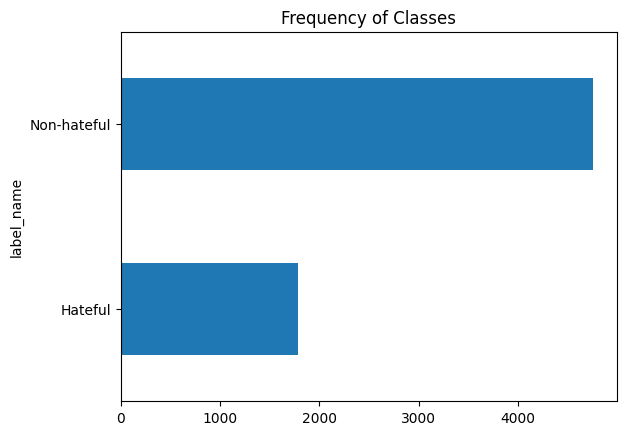

In [177]:
#Complete cell

import matplotlib.pyplot as plt

df_hs["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [178]:
q3.hint()
q3.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Visualize the class distribution in your hate speech dataset using a bar plot. Use value_counts() to count occurrences of each class, then create a horizontal bar plot. Class imbalance is common in hate speech detection and affects model performance.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
import matplotlib.pyplot as plt
df_hs["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()
```

In this case, we can see that the dataset is heavily imbalanced. We could try and find more hateful Tweet examples, but we skip this here. Instead let's look how long the Tweets are. This is important for several reasons. We have already discussed the impact of text lengths in the lecture but for language models there is also an important additional reason. Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. This is what they can see from a text at any particular moment in time, because of the way that they have been trained.

Let's look at a leaner version of the already mentioned BERT language model called DistilBERT (https://huggingface.co/docs/transformers/en/model_doc/distilbert). According to this documentation, its maximum context size is 512 tokens, which amounts to a few paragraphs of text. This should be fine for Tweets but let's check. Complete the cell below to visualise the Tweet lengths.

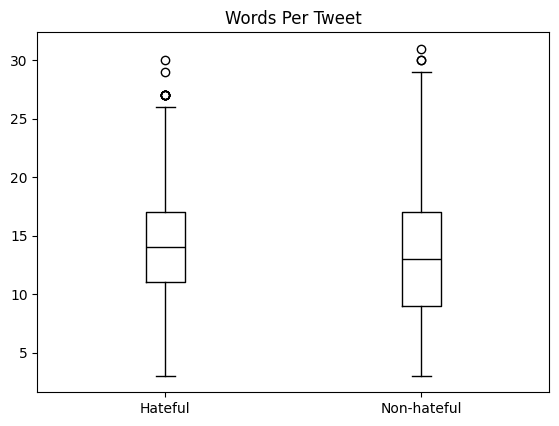

In [179]:
#Complete cell

df_hs["Words Per Tweet"] = df_hs["tweet"].str.split().apply(len)
df_hs.boxplot("Words Per Tweet", by="label_name", grid=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [180]:
q4.hint()
q4.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Analyze text length patterns across different classes using box plots. First, create a 'Words Per Tweet' column by splitting text and counting words. Then use boxplot() to compare word count distributions between hateful and non-hateful tweets. Text length can be a useful feature for classification.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
df_hs["Words Per Tweet"] = df_hs["tweet"].str.split().apply(len)
df_hs.boxplot("Words Per Tweet", by="label_name", grid=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
```

Most Tweets are around 15 words long and even the longest Tweets are well below DistilBERT's maximum context size. If that would not be the case, we have to apply specific methods to reduce the lengths of the input texts. Or we 'chunk' the texts into smaller parts: https://cobusgreyling.medium.com/chunking-for-llms-using-haystack-huggingface-81255776d71.

Before we do anything else, we have to reset the output format of our dataset since we don't need the dataframe-format anymore. Run `hatespeech_local.reset_format()`.

In [181]:
hatespeech_local.reset_format()

We have already talked about tokens/tokenization a bit in the lecture but what are they in the Transformers world? Let's find out next.

## From Text to Tokens

As said, tokenization is the second important step for Transformers after loading the datasets. Models like DistilBERT cannot process strings but need  _tokenized_ texts that are _encoded_ as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into sub-units is learned from the corpus nowadays.

Let's consider the two cases, which have been most common before Transformers: _character_ and _word_ tokenization.

### Character Tokenization

The simplest tokenization scheme is to feed each character individually to the model. In Python, `str` objects are implemented as collections of characters, which allows us to quickly implement character-level tokenization with just one line of code. Run the cell below.

In [182]:
#Keep cell
text = "Tokenizing text is fun but also strange. Even poetry becomes a number!"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'f', 'u', 'n', ' ', 'b', 'u', 't', ' ', 'a', 'l', 's', 'o', ' ', 's', 't', 'r', 'a', 'n', 'g', 'e', '.', ' ', 'E', 'v', 'e', 'n', ' ', 'p', 'o', 'e', 't', 'r', 'y', ' ', 'b', 'e', 'c', 'o', 'm', 'e', 's', ' ', 'a', ' ', 'n', 'u', 'm', 'b', 'e', 'r', '!']


Afterwards, we need to convert each character into an integer, a process  called _numericalization_. Deep learning/transformers requires all input to be numbers. Numericalisation is easy for characters by simply assigning them a unique integer. The code below is typical for Transformers. It creates a dictionary, which maps tokens (here characters) to numbers by assigning an integer to them - in the order of appearance of the tokens. Run the cell.

In [183]:
#Keep cell
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '!': 1, '.': 2, 'E': 3, 'T': 4, 'a': 5, 'b': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'x': 23, 'y': 24, 'z': 25}


We can now use `token2idx` to transform the tokenized text to a list of integers. Complete the cell below.

In [184]:
#Complete cell
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 16, 12, 8, 15, 11, 25, 11, 15, 10, 0, 20, 8, 23, 20, 0, 11, 19, 0, 9, 21, 15, 0, 6, 21, 20, 0, 5, 13, 19, 16, 0, 19, 20, 18, 5, 15, 10, 8, 2, 0, 3, 22, 8, 15, 0, 17, 16, 8, 20, 18, 24, 0, 6, 8, 7, 16, 14, 8, 19, 0, 5, 0, 15, 21, 14, 6, 8, 18, 1]


In [185]:
q5.check()
#q5.hint()
q5.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
input_ids = [token2idx[token] for token in tokenized_text]
```

With a bit more processing, we could use these numbers based on characters for the deep-learning model. But we move on and look at word tokenization.

### Word Tokenization

Instead of splitting the text into characters, we can split it into words, as we have seen in the lecture, and map each word to an integer. One simple class of word tokenizers, we have already seen, uses whitespaces to tokenize the text. We can do this by applying Python's `split()` function directly on the raw text - just like we did to measure the Tweet lengths.

Run the cell below.

In [186]:
#Keep cell
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'fun', 'but', 'also', 'strange.', 'Even', 'poetry', 'becomes', 'a', 'number!']


There are several problems with this approach. Most importantly maybe, it does not consider the position of a word and its context. Furthermore, the resulting vocabulary can be very large very quickly. This requires very big neural nets and makes their training very expensive.

A common mitigation approach is to limit the vocabulary and discard rarer words and only keep, say, the 100,000 most common words. Words that are not part of the limited vocabulary are classified as 'unknown' and mapped to a shared `UNK` token. You will encounter this approach quite frequently, but this also means that we lose some potentially important information in the process of word tokenization.

Wouldn't it be nice if there was a compromise between character and word tokenization that preserves all the input information _and_ some of the input structure? _subword tokenization_ addresses this.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size.

The main distinguishing feature of subword tokenization (as well as many forms of modern word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms, similar to what we have seen for Word2Vec in the lecture. Subword tokenization is a very active research field in computer science. Here, we only focus on its application, which is very easy with Hugging Face.

The subword tokenizer WordPiece (https://ieeexplore.ieee.org/document/6289079) is used by BERT and DistilBERT. The easiest way to understand how WordPiece works is to observe it in action. `transformers` provides a convenient `AutoTokenizer` class that allows you to quickly auto-load the tokenizer associated with a model. We just call the `from_pretrained()` method. We also define a so-called 'checkpoint', which one can think of as the latest save of the model. In this case, it is the latest version of the DistilBERT model https://huggingface.co/distilbert/distilbert-base-cased. This version of DistilBERT makes no difference between lower and upper cases in English.

Run the cell below.

In [187]:
#Keep cell
from transformers import AutoTokenizer

checkpoint = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The `AutoTokenizer` class belongs to a larger set of so-called 'auto' classes (https://huggingface.co/docs/transformers/model_doc/auto), whose job it is to automatically retrieve a model's configuration,  weights, etc. from its latest checkpoint. This allows you to quickly switch between models, but you can also load the specific model manually.

At the beginning of your learning journey, it is best to rely as much on 'auto' classes as possible. Later on, you will see that we could have also loaded the DistilBERT tokenizer directly. For instance, you could type in:
```
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```
Check it out online if you want but we move on for now.

We want to see `tokenizer` in action with our earlier defined `text`. Complete the cell below.

In [188]:
#Complete cell
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1706, 6378, 4404, 3087, 1110, 4106, 1133, 1145, 4020, 119, 2431, 4678, 3316, 170, 1295, 106, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [189]:
q6.hint()
q6.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Use a pre-trained tokenizer to encode text into the format expected by transformer models. Modern tokenizers handle subword tokenization, special tokens, and attention masks automatically. Simply call tokenizer(text) to get input_ids, attention_mask, and other required tensors.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
encoded_text = tokenizer(text)
print(encoded_text)
```

Every subword has now a unique integer in the `input_ids` field. You can ignore `attention_mask`. With `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method. Run the next cell.

In [190]:
#Keep cell
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'To', '##ken', '##izing', 'text', 'is', 'fun', 'but', 'also', 'strange', '.', 'Even', 'poetry', 'becomes', 'a', 'number', '!', '[SEP]']


Let's run a quick test that all is good.

In [191]:
# Run this cell to test your code...
assert tokens[-1]=='[SEP]', f'Test failed'
print('All tests passed!')

All tests passed!


From the output, we can observe three things:
1. Some special tokens, `[CLS]` and `[SEP]`, have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence.
1. The tokens have each been lowercased, which is a feature of this version of DistilBERT.
1. Finally, we can see that the word 'tokenizing', e.g., has been split into two tokens, since it is not a common word. The `##` prefix in `##izing` means that the preceding string is not a whitespace. With the prefix, we can convert them back.

The `AutoTokenizer` class has a `convert_tokens_to_string()` method for converting tokens back. Complete the next cell.

In [192]:
#Complete cell
tokenizer.convert_tokens_to_string(tokens)

'[CLS] Tokenizing text is fun but also strange. Even poetry becomes a number! [SEP]'

In [193]:
q7.hint()
q7.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Convert tokenized text back to human-readable format using the tokenizer. The convert_tokens_to_string() method reconstructs text from tokens, handling subword pieces and special formatting. This is useful for debugging and understanding tokenization.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
tokenizer.convert_tokens_to_string(tokens)
```

The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size or number of tokens with `tokenizer.vocab_size`. `vocab_size` is an attribute of `tokenizer` and `.` gives you access to these. Try to print out `tokenizer.vocab_size`.

In [194]:
tokenizer.vocab_size

28996

The model's maximum context size or its maximum number of tokens is provided by `tokenizer.model_max_length`.

In [195]:
tokenizer.model_max_length

512

With this basic understanding of the tokenization process, let's see how we can tokenize the whole dataset.

### Tokenizing the Whole Dataset

To tokenize the whole dataset, we will use the `map()` method of our `DatasetDict` object. To this end, we need a processing function to tokenize our examples. Run the cell below to define this function.

In [196]:
#Keep cell
def tokenize(batch):
    return tokenizer(batch["tweet"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. Just ignore these for the time being. Always, set them to True if you create your own tokenizer at the beginning.

Creating your own tokenizer is simple using this example code. You just have to define the `tokenizer` function in the example above for your own Tokenizer.

To see `tokenize()` in action, let's pass a batch of two examples from the training set. Run the cell below.

In [197]:
#Keep cell
tokenize(hatespeech_local["train"][:2])

{'input_ids': [[101, 26704, 1480, 1120, 1250, 2086, 170, 1480, 1228, 2013, 117, 188, 9332, 1183, 117, 189, 1964, 117, 8888, 1105, 25865, 1916, 119, 100, 102], [101, 1128, 13671, 1103, 2630, 1149, 1104, 1143, 108, 5358, 21412, 108, 2298, 108, 5528, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

Here we can see the result of padding. The second example is shorter than the first. So, zeros have been added to that element to make 'pad' them to the same length. Again, ignore `attention_mask`.

The zeros have a corresponding `[PAD]` token in the vocabulary as a special token. The set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier. Run the cell below to see the IDs of special tokens.

In [198]:
#Keep cell
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
pd.DataFrame(data, columns=["Special Token", "Special Token ID"]).T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


With the tokenization function `tokenize(batch)`, we can apply it across all the splits in the dataset very easily with `map()`. We print the column_names of 'test' to demonstrate our success. Run:
```
hatespeech_encoded = hatespeech_local.map(tokenize, batched=True, batch_size=None)
print(hatespeech_encoded["test"].column_names)
```

In [199]:
hatespeech_encoded = hatespeech_local.map(tokenize, batched=True, batch_size=None)
print(hatespeech_encoded["test"].column_names)

['id', 'label', 'tweet', 'input_ids', 'attention_mask']


Hugging Face's Transformers assume that your target variable has the column name 'labels' and the textual input is 'text'. Therefore, we need to rename the columns with `rename_columns()`. Run the cell below.

In [200]:
#Keep cell
hatespeech_encoded = hatespeech_encoded.rename_columns({'label':'labels', 'tweet': 'text'})
print(hatespeech_encoded["test"].column_names)

['id', 'labels', 'text', 'input_ids', 'attention_mask']


This is just an exercise. So, let us reduce the training and test datasets, which is surprisingly hard with Hugging Face at the time of writing. The cell below takes care of that, by picking up 50% of the datasets. It is a bit complicated but a good exercise to try and understand the various parts. Also, it might be useful for the future when you are working with your own datasets.

Run the cell.

In [201]:
#Keep cell
frac_ = 0.5

train_frac = int(hatespeech_encoded["train"].num_rows * frac_)
test_frac = int(hatespeech_encoded["test"].num_rows * frac_)

hatespeech_encoded_train_small = hatespeech_encoded["train"].shuffle(seed=42).select(range(train_frac))
hatespeech_encoded_test_small = hatespeech_encoded["test"].shuffle(seed=42).select(range(test_frac))

Let's print out `hatespeech_encoded_train_small` and `hatespeech_encoded_test_small` to check that everything looks alright.

In [202]:
hatespeech_encoded_train_small

Dataset({
    features: ['id', 'labels', 'text', 'input_ids', 'attention_mask'],
    num_rows: 3274
})

In [203]:
hatespeech_encoded_test_small

Dataset({
    features: ['id', 'labels', 'text', 'input_ids', 'attention_mask'],
    num_rows: 819
})

## Transformer Models

DistilBERT is pretrained to predict masked words in a sequence of text. Let's say we have a sentence 'The house has a garden.' Then, house might be hidden with 'The ___ has a garden.' DistilBERT learns that 'house' has likely been hidden. This learning task allows the model to collect a lot of information on languages in general, but not on the particular text classification task like hate-speech detection. We need to modify the baseline language models. The next step is then to 'fine-tune' a model like DistilBERT for a particular task like in our case hate-speech analysis. Do you remember the lecture?

### Baseline

Before we investigate fine-tuning we want to quickly run a baseline model to compare our Transformer results to. In our case, this will be the dictionary-based one that we have already discussed. Run the next cell to add a column of hate_score to `df_hs`. Note that this is still a sample and not the full dataset.

Do you remember the code from the lecture? The cell puts it all together.

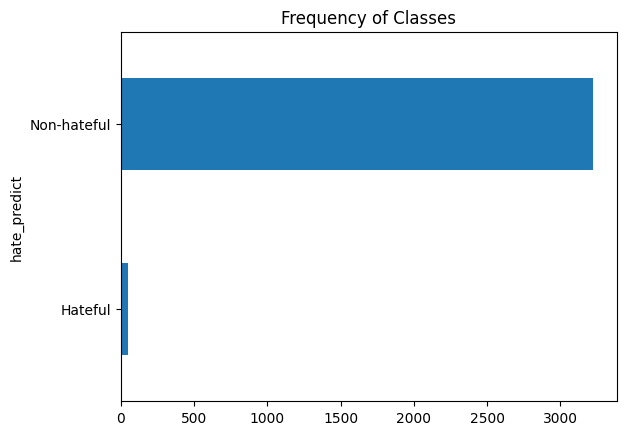

In [204]:
# Keep cell
# Repeat dictionary-based sentiment analysis

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords_ = list(stopwords.words('english'))
neg_words = list(set(list(pd.read_csv('https://raw.githubusercontent.com/goto4711/social-cultural-analytics/master/hate-vocab-eng.csv')['word'])))

def hate_score_(text):
    score = 0
    words = [word.lower() for word in word_tokenize(text)]
    for word in words:
        if word in neg_words:
            score += 1
    return score

df_hs = df_hs.sample(frac=frac_, random_state=1)

df_hs['hate_score'] = df_hs['tweet'].apply(hate_score_)
df_hs['hate_predict'] = np.where((df_hs['hate_score'] > 0), 'Hateful', 'Non-hateful')

df_hs["hate_predict"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

`hate_score_` counts the number of times a word from the hatespeech dictionary appears in the tweets. It assigns that count to `df_hs['hate_score']`. If the hate_score is larger than 0, the Tweet is predicted to be 'Hateful' and otherwise 'Non-hateful'.

Let's calculate the accuracy:

In [205]:
#Keep cell
from sklearn.metrics import accuracy_score

accuracy_score(df_hs["label_name"], df_hs["hate_predict"])

0.7281612706169823

The accuracy looks ok and much better than guessing either of the two labels, which would be 0.5 However, this is mainly because the dominant 'Non-hateful' class is predicted correctly, as the confusion matrix shows. Run the cell below.

In [206]:
#Keep cell
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_hs["label_name"], df_hs["hate_predict"], labels=["Non-hateful", "Hateful"])
pd.DataFrame(cm, columns = ["Non-hateful", "Hateful"], index = ["Non-hateful", "Hateful"])

,Non-hateful,Hateful
Non-hateful,2369,35
Hateful,855,15


The model pretty much fails to predict hateful Tweets and is not useful in practice. You should be very sceptical if companies just present basic accuracy to praise their models.

At least we now have a baseline of accuracy we aim to improve by fine-tuning pretrained Transformer models. Before we do this, we have to run the slightly strange looking code below, which runs the model on a GPU (or MPS for Macs) if available rather than a CPU. This makes running Transformers much faster. GPUs are the basic hardware language modelling uses to efficiently calculate billions of operations. If you are interested in the different options check out https://raoofnaushad7.medium.com/difference-between-cuda-and-mps-3d2596629c89.

Run the code below to set the default device to run our model on as either CUDA(GPU), MPS or CPU.

In [207]:
#Keep cell

if torch.cuda.is_available():
    DEFAULT_DEVICE = "cuda"
else:
    if torch.backends.mps.is_available():
        DEFAULT_DEVICE = "mps"
    else:
        DEFAULT_DEVICE = "cpu"
device = torch.device(DEFAULT_DEVICE)
print(DEFAULT_DEVICE)

cuda


It should print out the device you are using. In my case it would be 'mps' for my home computer and 'cuda' on Google Colab if you connected the runtime correctly. If you see 'cpu', start from the beginning, connect the right runtime and run all cells above again.

Let's go on and finally fine-tune.

### Fine-Tuning Transformers

We want to fine-tune the pretrained DistilBERT model and first need to get it from `AutoModelForSequenceClassification`. The Hugging Face `AutoModelForSequenceClassification` model has a so-called classification _head_ on top of the pretrained model body, which can be trained. We just need to specify how many labels the model has to predict since this dictates the number of outputs the classification head has. We set `num_labels=2` for the binary choice of hate_speech or not.

Run the cell below. The most important line is `model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)`, which uses the `checkpoint = "distilbert-base-cased"` from the tokenizer above to load `AutoModelForSequenceClassification` for a binary classification (`num_labels=2`). `to(device)` sends the calculations to our default device, which should be cuda on Colab.

In [208]:
#Keep cell
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)

You might see some warnings in the following code about Hugging Face versions. Please ignore these for this session.  

The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning. To this end, Hugging Face requires a `compute_metrics()` function for its `Trainer` that we will define later.  This function receives a `pred`, which is a  tuple with `predictions` and `label_ids` attributes. It has to return a dictionary that maps each metric's name to its value.

For our classification application, we will compute the accuracy of the model, as this allows us to compare with our baseline. Try and understand the cell below and run it. You can reuse this function or a similar one for many Hugging Face classifications. Just keep it in mind.

Run the cell below.

In [209]:
#Keep cell
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

### Training the model

To run the Hugging Face `trainer` (https://huggingface.co/docs/transformers/main_classes/trainer), we first define some of its parameters with `TrainingArguments`. It stores a lot of information and gives you fine-grained control over training and evaluation. You can ignore most of the arguments for now, as they are used for reporting only. Just copy and paste `TrainingArguments` next time you want to use it.

The most important argument  is `output_dir`, which is where all the files from training are stored. Three more parameters are important. `batch_size` defines the number of examples to work through before updating internal model parameters. It has a lot to do with what your machine can process in its memory at any moment in time. At the beginning, it is probably a good idea not to go beyond 128 and if you have problems use 64 or 32 as batch size. You computer will complain a lot if you get the batch size wrong. Thus, if you see strange memory errors, a good idea is always to first reduce the batch size. This generally leads to longer processing times though, because fewer records are processed at the same pass. `epochs` are the number of passes through the network. The larger the number of epochs the higher the chances for the network to learn, but it also takes much longer. For demonstration purposes, we set `epochs = 2`. Finally, `learning_rate=2e-5` sets the speed of updating parameters in deep-learning models.

Run the cell below.

In [210]:
#Keep cell
from transformers import TrainingArguments

batch_size = 128
epochs = 2

training_args = TrainingArguments(output_dir=f"{checkpoint}-finetuned-emotion",
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to="none")


We can can now fine-tune our model with the `Trainer`. Check the documentation for the explanation of the arguments.

Run the next cell. This might take a while as you are now doing really advanced stuff.

In [211]:
#Keep cell
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=hatespeech_encoded_train_small,
                  eval_dataset=hatespeech_encoded_test_small,
                  processing_class=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.412672,0.752137
2,No log,0.318664,0.885226


Looking at the logs, we can see that our model has an accuracy on the test dataset of > 88%, which is a great improvement on our baseline dictionary-based method.

To visualize the confusion matrix next, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects for evaluation. Run the cell below.

In [212]:
#Keep cell
preds_output = trainer.predict(hatespeech_encoded_test_small)

Run another test that you are on the right way.

In [213]:
# Run this cell to test your code...
assert len(preds_output) == 3, f'Test failed'
print('All tests passed!')

All tests passed!


The output of the `predict()` contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics can be accessed with `preds_output.metrics`. Try it.

In [214]:
preds_output.metrics

{'test_loss': 0.31866395473480225,
 'test_accuracy': 0.8852258852258852,
 'test_runtime': 1.3754,
 'test_samples_per_second': 595.469,
 'test_steps_per_second': 5.089}

`preds_output` also contains the raw predictions for each class. A single prediction has one value for each class: 'Non-hateful' and 'Hateful'. Take a look at the first prediction by running the cell below.

In [215]:
#Keep cell
preds_output.predictions[0]

array([-0.35735616,  0.2966149 ], dtype=float32)

You will remember the outputs of classifications we have seen before? As always we get two outputs, one for each class, and we simply choose the larger one.

We can decode the predictions and select always the most likely class by using `np.argmax()`. `np.argmax` returns the indices of the maximum values. So in my output, it would return 1 has the 1 index is larger than the 0 index. In your case, this might look differently.

In my case, 1 rightly predicts a 'hateful' Tweet. We can run `np.argmax()` against all the predictions at the same time with `y_preds = np.argmax(preds_output.predictions, axis=1)`. `axis=1` indicates a row-wide comparison.



In [216]:
y_preds = np.argmax(preds_output.predictions, axis=1)

Print out the first ten y_preds next.

In [217]:
y_preds[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [218]:
q8.check()
#q8.hint()
q8.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
y_preds[:10]
```

Run another test.

In [219]:
# Run this cell to test your code...
assert len(y_preds) > 810, f'Test failed'
print('All tests passed!')

All tests passed!


With the predictions, we can plot the confusion matrix. Complete the cell below by looking back at the earlier example or using the documentation for `confusion_matrix`.

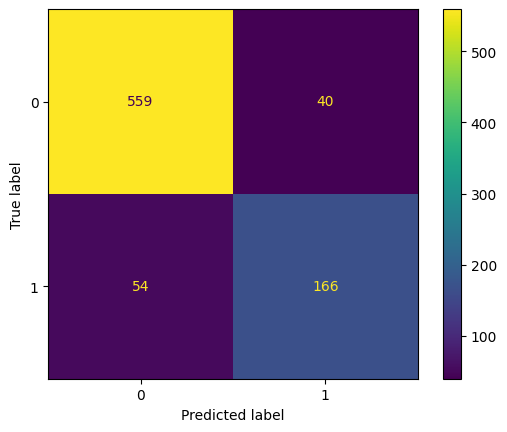

In [220]:
#Complete cell
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = np.array(hatespeech_encoded_test_small["labels"])

cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot()
plt.show()

In [221]:
q9.hint()
q9.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Create a confusion matrix to evaluate your hate speech classification model. Import confusion matrix tools from sklearn.metrics, extract true labels from your test data, then create and display the confusion matrix. This shows true positives, false positives, etc.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test = np.array(hatespeech_encoded_test_small["labels"])
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
```

This is much better. Now, the model is actually able to predict 'hateful' Tweets (label=1).

We can also run our own Tweet examples by using Hugging Face's pipeline. This is also called inference for language models.

Run the cell below to define `pipe` and set up a `TextClassificationPipeline`. A Hugging Face `pipeline` (https://huggingface.co/docs/transformers/en/main_classes/pipelines) allows us to bring together several steps. In this case, we 'pipe' the tokenizer into the model. Please, observe that we have to move the model back to the 'cpu' first. Otherwise, the tokenizer and model are on different devices. Can you identify in the code how we do this? It's easy.

In [222]:
#Keep cell
from transformers import TextClassificationPipeline
pipe = TextClassificationPipeline(model=model.to('cpu'), tokenizer=tokenizer)

Let's test the pipeline with two example Tweets, taken from my test data. Run the cell below.

In [223]:
#Keep cell
nice_tweet = "'i am looking forward to seeing it!! @user @user'"
print('Nice Tweet: ', pipe(nice_tweet, top_k=None))

bad_tweet = "black genius v white supremacy are you missing the action? the #freemasons being taught a lesson about .'."
print('Bad Tweet: ', pipe(bad_tweet, top_k=None))

Nice Tweet:  [{'label': 'LABEL_0', 'score': 0.9510625004768372}, {'label': 'LABEL_1', 'score': 0.04893752187490463}]
Bad Tweet:  [{'label': 'LABEL_1', 'score': 0.6788424253463745}, {'label': 'LABEL_0', 'score': 0.3211575746536255}]


As you can see, the model correctly predicts non-hateful content for `nice_tweet` with a higher score for 'LABEL_0'. It is also right for the `bad_tweet`. Try some other Tweet texts!

Congratulations, you now know how to train a Transformer model to classify Tweets. This can only be the beginning but hopefully you found it interesting. The most important lesson to remember are the processing steps from the Hugging Face figure above, which are very standard and repeat themselves. The steps are also repeated in the first chapter of the Transformers book with some added extra explanations: _Lewis Tunstall, Leandro von Werra, Thomas Wolf (2022): Natural Language Processing with Transformers, O'Reilly Media, Inc. While inspired by the book, we have changed the datasets, adjusted the task and removed some additional content. But the book is a great introduction to NLP with Transformers written by the Hugging Face team. It is, however, quickly getting outdated by changes to the Hugging Face libraries.

Does this look scary? Maybe, but it is actually always the same steps. Why not ask Gemini whether it can do. This time, do not use a code cell directly but click on Gemini symbol. A chat interface opens. Ask Gemini to "classify from ds the label from tweet using HuggingFace's DestilBERT". It should print out the same steps we have just gone through and create the code for you. I just had to make a few simple adjustments.

In [224]:
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch

# --------------------------------------------------
# 1. Load dataset
# --------------------------------------------------
df = pd.read_csv("TwitterHate_Small.csv")

dataset = Dataset.from_pandas(df)
dataset = dataset.rename_column("tweet", "text")
dataset = dataset.class_encode_column("label")

# --------------------------------------------------
# 2. Load tokenizer + model
# --------------------------------------------------
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=dataset.features["label"].num_classes
)

# --------------------------------------------------
# 3. Tokenization
# --------------------------------------------------
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.with_format("torch")

# --------------------------------------------------
# 4. Train/test split
# --------------------------------------------------
train_test = tokenized.train_test_split(test_size=0.2)
train_dataset = train_test["train"]
test_dataset = train_test["test"]

# --------------------------------------------------
# 5. TrainingArguments (VALID FOR 4.57.2)
# --------------------------------------------------
training_args = TrainingArguments(
    output_dir="distilbert-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"     # ← disables wandb so no login prompt
)

# --------------------------------------------------
# 6. Trainer
# --------------------------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# --------------------------------------------------
# 7. Prediction helper
# --------------------------------------------------
def predict(text):
    device = model.device              # ← automatically detects "cuda" or "cpu"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}   # ← move inputs to same device
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=1).item()


df["predicted_label"] = df["tweet"].apply(predict)
df.head(10)


Stringifying the column:   0%|          | 0/8186 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/8186 [00:00<?, ? examples/s]

Map:   0%|          | 0/8186 [00:00<?, ? examples/s]

{'loss': 0.4871, 'grad_norm': 3.6113412380218506, 'learning_rate': 1.880487804878049e-05, 'epoch': 0.12195121951219512}
{'loss': 0.3247, 'grad_norm': 3.796311140060425, 'learning_rate': 1.7585365853658538e-05, 'epoch': 0.24390243902439024}
{'loss': 0.2671, 'grad_norm': 1.3832191228866577, 'learning_rate': 1.6365853658536587e-05, 'epoch': 0.36585365853658536}
{'loss': 0.2849, 'grad_norm': 2.880028247833252, 'learning_rate': 1.5146341463414636e-05, 'epoch': 0.4878048780487805}
{'loss': 0.2541, 'grad_norm': 5.264533042907715, 'learning_rate': 1.3926829268292683e-05, 'epoch': 0.6097560975609756}
{'loss': 0.2689, 'grad_norm': 2.823333740234375, 'learning_rate': 1.2707317073170734e-05, 'epoch': 0.7317073170731707}
{'loss': 0.2548, 'grad_norm': 6.260709762573242, 'learning_rate': 1.1487804878048781e-05, 'epoch': 0.8536585365853658}
{'loss': 0.2517, 'grad_norm': 0.8508898615837097, 'learning_rate': 1.026829268292683e-05, 'epoch': 0.975609756097561}
{'eval_loss': 0.23886723816394806, 'eval_runt

,id,label,tweet,predicted_label
0,14,1,@user #cnn calls #michigan middle school 'buil...,1
1,15,1,no comment! in #australia #opkillingbay #se...,1
2,18,1,retweet if you agree!,1
3,24,1,@user @user lumpy says i am a . prove it lumpy.,1
4,35,1,it's unbelievable that in the 21st century we'...,1
5,57,1,@user lets fight against #love #peace,0
6,69,1,ð©the white establishment can't have blk fol...,1
7,78,1,"@user hey, white people: you can call people '...",1
8,83,1,how the #altright uses &amp; insecurity to lu...,1
9,112,1,@user i'm not interested in a #linguistics tha...,1


The next example is taken from another wonderful resource: the FastAI training course. The patents' case study repeats once more the steps how to use Transformers for text analysis. The corresponding book is _@Howard, J. and Gugger, S. (2020): Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD, O'Reilly Media, Inc._ It is open access at https://www.fast.ai/.

Let's take a look at their example for text classification, which introduces another twist showcasing the power of language models. Before this new twist, many NLP tasks were tackled with specialized models, as we have seen. For example:

- Classification tasks (like sentiment analysis) used models that output class labels.
- Translation models outputted target-language sentences.


Now, we can use only LLMs, their training procedure and code, for a wide range of NLP problems by simply saying that all these different things can be mapped towards text-to-text input-outputs. Check out this famous paper that summarises the idea: https://arxiv.org/pdf/1910.10683.

## Case Study: Text Classification Patents

In my research, I have used text analysis extensively to analyse Tweets. But I have also been interested in patents to understand corporate practices in relation to deep learning, which has inspired me to this case study. We will analyse the Kaggle U.S. Patent Phrase to Phrase Matching competition from https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/. It is described as matching different phrases:

"In this competition, you will train your models on a novel semantic similarity dataset to extract relevant information by matching key phrases in patent documents. Determining the semantic similarity between phrases is critically important during the patent search and examination process to determine if an invention has been described before. For example, if one invention claims "television set" and a prior publication describes "TV set", a model would ideally recognize these are the same and assist a patent attorney or examiner in retrieving relevant documents. This extends beyond paraphrase identification; if one invention claims a "strong material" and another uses "steel", that may also be a match. What counts as a "strong material" varies per domain (it may be steel in one domain and ripstop fabric in another, but you wouldn't want your parachute made of steel). We have included the Cooperative Patent Classification as the technical domain context as an additional feature to help you disambiguate these situations."

Thus, we want to compare two words or short phrases in order to score them whether they are similar or not in a particular context, based on which patent class they were used in. With a score of 1, the two inputs are considered to have identical meaning, while 0 means that they have totally different meaning. 'Abatement' (https://www.dictionary.com/browse/abatement) and 'eliminating process', e.g., have a score of 0.5, meaning they are somewhat similar but not identical. I have to trust that this is right, as they are specific patent ideas with their own meanings, which I know very little about. You will meet a couple of these in this case study.

### Preparing the data

The first step to prepare the data is to download it from Kaggle. If you want to do this by yourself, you need a free account with Kaggle. Please go and register with Kaggle (https://www.kaggle.com/discussions/getting-started/45113).

The library `opendatasets` takes care of all the issues with downloading datasets from online sources with authentication. Uncommenting the line `od.download('https://www.kaggle.com/datasets/atharvaingle/uspppm-data')` and running it, might prompt you for your username and password to access Kaggle. You also need a so-called API key, which can be difficult to find (https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/). They will be covered again later in the course. If you have problems, come and talk to us.

In this case, you should anyway not have to download any data, as we have done this already for you. But it is good to learn about downloading data from Kaggle for the future.

Run the cell below.

In [225]:
# Keep cell
# Download to folder ./uspppm-data
import opendatasets as od

if os.path.exists('./uspppm-data'):
    print('Data already downloaded')
else:
    print('Make sure to download the data by running the set-up cells or run the next line to connect to Kaggle.')
    #od.download('https://www.kaggle.com/datasets/atharvaingle/uspppm-data')


Data already downloaded


Let's load the data into a dataframe `df_pat`. Complete the cell below and print out `df_pat.info()` and `df_pat.head(3)`.

In [226]:
#Complete cell

df_pat = pd.read_csv('./uspppm-data/train.csv')
print(df_pat.info())
df_pat.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB
None


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25


In [227]:
q10.check()
#q10.hint()
q10.solution()


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
df_pat = pd.read_csv('./uspppm-data/train.csv')
print(df_pat.info())
print(df_pat.head(3))
```

The data looks quite strange, but it is explained at https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data. The  columns stand for:
- id - a unique identifier for a pair of phrases.
- anchor - the first phrase.
- target - the second phrase.
- context - the CPC classification (version 2021.05), which indicates the subject within which the similarity is to be scored.
- score - the similarity, which is sourced from a combination of one or more manual expert ratings.

Let's run a quick test that everything is loaded ok.

In [228]:
# Run this cell to test your code...
assert df_pat.shape[0] == 36473, f'Test failed'
print('All tests passed!')

All tests passed!


By typing in `df_pat['anchor'].value_counts()`, we see that there is a wide variety of first phrases.

In [229]:
df_pat['anchor'].value_counts()

,count
anchor,
component composite coating,152
sheet supply roller,150
source voltage,140
perfluoroalkyl group,136
el display,135
...,...
shannon,2
plug nozzle,2
dry coating composition1,2


The similarity matching we are looking for is made more difficult by the fact that it is dependent on the context of the patent class or CPC classification. Can you change the last expression so that we get the counts for `df_pat['context']`?

In [230]:
df_pat['context'].value_counts()

,count
context,
H01,2186
H04,2177
G01,1812
A61,1477
F16,1091
...,...
B03,47
F17,33
B31,24


In [231]:
q11.hint()
q11.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Analyze the distribution of different contexts in your patient data. Use value_counts() on the 'context' column to see how many examples exist for each context type. Understanding context distribution helps with model training and evaluation strategies.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
df_pat['context'].value_counts()
```

Finally, let's look at our target variable, which is `score`. Run `value_counts()` against the target.

In [232]:
df_pat['score'].value_counts()

,count
score,
0.50,12300
0.25,11519
0.00,7471
0.75,4029
1.00,1154


Again, we find a large variety of different scores. Later, we will simplify them, but let's first take a look at examples of each of them. Run the cell below, which is also an example of the power of `print()` by making heavy use of the f-strings we met at the beginning of the course: https://www.geeksforgeeks.org/python/formatted-string-literals-f-strings-python/. It's very useful knowledge from now on as we are dealing with a lot of transformations of text.

In [233]:
#Keep cell

def print_relation(i):
    return f"WITHIN {df_pat['context'][i]}, THE PHRASE {df_pat['target'][i]} AND THE PHRASE {df_pat['anchor'][i]} HAVE SIMILARITY {df_pat['score'][i]}"

print(print_relation(311))
print(print_relation(1))
print(print_relation(100))
print(print_relation(1500))
print(print_relation(35985))

WITHIN B08, THE PHRASE absorption of acid AND THE PHRASE acid absorption HAVE SIMILARITY 1.0
WITHIN A47, THE PHRASE act of abating AND THE PHRASE abatement HAVE SIMILARITY 0.75
WITHIN E03, THE PHRASE abnormal AND THE PHRASE abnormal position HAVE SIMILARITY 0.5
WITHIN C10, THE PHRASE petroleum oils AND THE PHRASE animal fats HAVE SIMILARITY 0.25
WITHIN B21, THE PHRASE durability codes for muscle legends AND THE PHRASE wearability HAVE SIMILARITY 0.0


How can we transform this data into something a language model can classify? We need to get creative and join various columns to create the input. We can then  rely on the language model to understand what it is supposed to do. This is a very elegant way of addressing the problem - also in comparison to the way we defined a classification task earlier. Compared to earlier, we just set up the language model in the right way - with the right kind of text for input and output - and do not need to add complicated programming techniques like particular models. This is why I have added this example to showcase the power of language modelling.

It has become a  text analytics skill to creatively format diverse inputs for a text-to-text model. People like to use very large language model to do specific tasks but then they need to speak to them in a text/language they understand. But this section also reiterates the tokenization and training steps to make you more familiar with the pattern. We will skip some details as the baseline comparison, as the goal is to show the process.

Let's take it one step a time and look at the first example. To a language model, the relation between 'absorption of acid' and 'acid absorption' within the context 'B08' can be represented using a joined text like (in a simplified notation):

```
'CON: ' + df_pat['context'] + '; PHARSE1: ' + df_pat['target'] + '; PHARSE2: ' + df_pat['anchor']
```

As you can see, we have added the columns to the text and concatenated all the important columns with `+`. Now the task is for the model to match these inputs to the target score in order to address the Patent Phrase Matching problem. Run:

```df_pat['input'] = 'CON: ' + df_pat['context'] + '; PHARSE1: ' + df_pat['target'] + '; PHARSE2: ' + df_pat['anchor']```.

For `df_pat`, we use `+` to concatenate the relevant columns into a new string and store it in the new column `input`. We cannot use f-strings directly on a Pandas series.

In [234]:
df_pat['input'] = 'CON: ' + df_pat['context'] + '; PHARSE1: ' + df_pat['target'] + '; PHARSE2: ' + df_pat['anchor']

Next, as promised, let's simplify the classification to a binary one.

Looking back at the output of `df_pat['score'].value_counts()`, a good split seems to be right in the middle. Please run `df_pat['score'] = np.where(df_pat['score']  < 0.5, 0, 1)`. Hopefully, you remember this step from our earlier examples like the music-quality classification.

In [235]:
df_pat['score'] = np.where(df_pat['score'] < 0.5, 0, 1)

Print out the first three rows of `df_pat` to check that everything is as desired.

In [236]:
df_pat.head(3)

,id,anchor,target,context,score,input
0,37d61fd2272659b1,abatement,abatement of pollution,A47,1,CON: A47; PHARSE1: abatement of pollution; PHA...
1,7b9652b17b68b7a4,abatement,act of abating,A47,1,CON: A47; PHARSE1: act of abating; PHARSE2: ab...
2,36d72442aefd8232,abatement,active catalyst,A47,0,CON: A47; PHARSE1: active catalyst; PHARSE2: a...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,1,CON: A47; PHARSE1: eliminating process; PHARSE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0,CON: A47; PHARSE1: forest region; PHARSE2: aba...


Let's also run a quick test to see that everything is ok.

In [237]:
# Run this cell to test your code...
assert df_pat.loc[100, 'input'] == 'CON: E03; PHARSE1: abnormal; PHARSE2: abnormal position', f'Test failed'
print('All tests passed!')

All tests passed!


Looks good. This is it in terms of initial data preparation. We are ready to tokenize next.

### Tokenization

This is also a good time to demonstrate how to create a Transformer dataset from a dataframe like `df_pad`. It's easy. Run the cell below.

In [238]:
#Keep cell

from datasets import Dataset, DatasetDict
ds_pat = Dataset.from_pandas(df_pat)
ds_pat

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

Our next step in the Hugging Face workflow is to pick a model from the hub for tokenization and prediction. Let's use the one that Fastai recommends: https://huggingface.co/microsoft/deberta-v3-small.

Run the cell below to get the checkpoint.

In [239]:
#Keep cell

checkpoint_pat = 'microsoft/deberta-v3-small'

Do you see how the steps with Transformers are repeating themselves?

The next step is to call AutoTokenizer and create a tokenizer appropriate for a given model. Complete the cell below by adding our model's checkpoint.

In [242]:
#Complete cell by adding the model's checkpoint

tokenizer_pat = AutoTokenizer.from_pretrained(checkpoint_pat)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [241]:
q12.hint()
q12.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Initialize a tokenizer for your specific model checkpoint. AutoTokenizer.from_pretrained() automatically loads the correct tokenizer for your model. Each pre-trained model has its own tokenizer that matches the vocabulary used during training.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
tokenizer_pat = AutoTokenizer.from_pretrained(checkpoint_pat)
```

A quick example shows us that we are working again with a subword tokenizer. Run the cell.

In [243]:
#Keep cell

tokenizer_pat.tokenize("Hello Amsterdam, I'm in a lovely city.")

['▁Hello',
 '▁Amsterdam',
 ',',
 '▁I',
 "'",
 'm',
 '▁in',
 '▁a',
 '▁lovely',
 '▁city',
 '.']

Looking back at the pipeline steps above, the next step is to define a function to tokenize all our inputs, which we call `tokenizer_pat_func`. Run
```
def tokenizer_pat_func(batch):
    return tokenizer_pat(batch["input"])
```

In [244]:
def tokenizer_pat_func(batch):
    return tokenizer_pat(batch["input"])

To run this quickly and in parallel on every row, you remember that you can use `map()`. Complete the cell below.

In [246]:
#Complete cell
ds_pat_encoded = ds_pat.map(tokenizer_pat_func, batched=True)
ds_pat_encoded

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [245]:
q13.hint()
q13.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Apply tokenization to your entire dataset using the map() function. Use batched=True for efficient processing of large datasets. The map() function applies your tokenizer function to all examples, creating the input format needed for transformer models.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
ds_pat_encoded = ds_pat.map(tokenizer_pat_func, batched=True)
ds_pat_encoded
```

As you can see, this adds a couple of encoded columns with the extension `_ids`.

Let's take a look at the encoded version of `input` for the first row of our data. Complete the cell below.

In [247]:
#Complete cell

print('input: ', ds_pat_encoded[0]['input'])
print('input_ids: ', ds_pat_encoded[0]['input_ids'])

input:  CON: A47; PHARSE1: abatement of pollution; PHARSE2: abatement
input_ids:  [1, 20967, 294, 336, 5753, 346, 916, 57900, 12547, 435, 294, 47284, 265, 6435, 346, 916, 57900, 12547, 445, 294, 47284, 2]


In [248]:
q14.hint()
q14.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Compare the original text input with its tokenized representation. Print both the original 'input' text and the tokenized 'input_ids' to understand how your text gets converted to numerical format that the model can process.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
print('input: ', ds_pat_encoded[0]['input'])
print('input_ids: ', ds_pat_encoded[0]['input_ids'])
```

Running `tokenizer_pat_func()`, we have created a vocabulary (`vocab`), which contains a unique integer for every possible token string.

E.g., to access the id of the word 'instance' we run `tokenizer_pat.vocab['instance']`.

In [249]:
tokenizer_pat.vocab['instance']

86493

Running a test next ...

In [250]:
# Run this cell to test your code...
assert tokenizer_pat.vocab['house'] == tokenizer_pat.vocab['house'], f'Test failed'
print('All tests passed!')

All tests passed!


Now try to access the index of 'amsterdam' and compare it with the index of 'jakarta'. What does this teach us about the distribution of data and inclusion of global regions in US patents?

In [251]:
#Keep cell

print(tokenizer_pat.vocab['amsterdam'])
#print(tokenizer_pat.vocab['jakarta']) gives KeyError

116948


Finally as we have already seen, Hugging Face's Transformers assume that your target variable has the column name 'labels', but in our dataset it is called 'score'. Therefore, we need to rename it. There is a `rename_columns()` function to do that. Run the cell below.

In [252]:
#Keep cell
ds_pat_encoded = ds_pat_encoded.rename_columns({'score':'labels'})

### Training, evaluation and test

Now that we have prepared our tokens and labels, we need to create our validation set. Kaggle often has a separate file for tests and validations.

Our downloaded data directory contains another file for the test data. Run the cell below to create `eval_df_pat`.

In [253]:
#Keep cell

eval_df_pat = pd.read_csv('./uspppm-data/test.csv')
eval_df_pat.head(3)

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60


As discussed, in machine learning we need to usually create distinct training, validation and test datasets. Earlier, we have skipped the validation dataset for demonstration purposes. So, let's show now how to add such a set.

The validation set is used to see how the model is doing during training, by, e.g., checking the model's predictions against the validation set at the end of an epoch. It is never used as input to training the model. The test dataset finally is only used at very end in order to evaluate the actual model. Please note that in the hate-speech example, we used the test dataset for the evaluation during training, as we did not have more data for a final test.

Let's use `train_test_split` to create a validation dataset. Remember, this is the Hugging Face version of the function and not to be confused with the one in sklearn. Check out https://huggingface.co/docs/datasets/en/process.

Run the cell below.

In [254]:
#Keep cell
ds_pat_encoded_final = ds_pat_encoded.train_test_split(0.25, seed=42)
ds_pat_encoded_final

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

As said, the test dataset is not involved in the training at all and only used at the very end. In the case of Kaggle, we could submit the results from the test data to a leadership board to be ranked with our performance. But we skip this here.

We use `eval_df_pat` as our name for the test dataset in order to avoid confusion with the test dataset that was created by `train_test_split`. Run the cell below, which brings the steps above together to prepare the test data.

In [255]:
#Keep cell

eval_df_pat['input'] = 'CON: ' + eval_df_pat['context'] + '; PHARSE1: ' + eval_df_pat['target'] + '; PHARSE2: ' + eval_df_pat['anchor']
eval_ds_pat = Dataset.from_pandas(eval_df_pat).map(tokenizer_pat_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

One more test whether you got it right.

In [256]:
# Run this cell to test your code...
assert eval_df_pat.loc[15,'input']  == 'CON: G02; PHARSE1: illumination; PHARSE2: el display', f'Test failed'
print('All tests passed!')

All tests passed!


### Training the model

Let's start training again and define our model with `model_pat = AutoModelForSequenceClassification.from_pretrained(model_pat, num_labels=2).to(device)`. Run the cell below, which also prints out the default device - just to check. Again, if you see 'cpu' here, you have to start from the beginning.

In [257]:
#Keep cell

model_pat = AutoModelForSequenceClassification.from_pretrained(checkpoint_pat, num_labels=2).to(device)
print('Default device: ', device)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Default device:  cuda


We are ready to start training again. For demonstration purposes, we will keep `compute_metrics()` and `training_args` from the Twitter example. This might not be a great idea in this case. We want to normally change the number of epochs or the learning rate for different data. But we want to mainly show you that the steps are very similar and are happy with slightly worse performance.

Run the cell below, which runs for quite a while depending on your hardware.

In [258]:
#Keep cell

from transformers import Trainer
trainer = Trainer(model_pat,
                  training_args,
                  train_dataset=ds_pat_encoded_final['train'],
                  eval_dataset=ds_pat_encoded_final['test'],
                  processing_class=tokenizer_pat,
                  compute_metrics=compute_metrics)

trainer.train()

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

{'loss': 0.6763, 'grad_norm': 2.1832334995269775, 'learning_rate': 1.971345029239766e-05, 'epoch': 0.029239766081871343}
{'loss': 0.5257, 'grad_norm': 11.85512924194336, 'learning_rate': 1.9421052631578948e-05, 'epoch': 0.05847953216374269}
{'loss': 0.5248, 'grad_norm': 6.13072395324707, 'learning_rate': 1.9128654970760235e-05, 'epoch': 0.08771929824561403}
{'loss': 0.5132, 'grad_norm': 4.497501850128174, 'learning_rate': 1.8836257309941522e-05, 'epoch': 0.11695906432748537}
{'loss': 0.484, 'grad_norm': 8.586848258972168, 'learning_rate': 1.854385964912281e-05, 'epoch': 0.14619883040935672}
{'loss': 0.4599, 'grad_norm': 6.128808975219727, 'learning_rate': 1.8251461988304097e-05, 'epoch': 0.17543859649122806}
{'loss': 0.4598, 'grad_norm': 12.467584609985352, 'learning_rate': 1.7959064327485384e-05, 'epoch': 0.2046783625730994}
{'loss': 0.4726, 'grad_norm': 6.086170673370361, 'learning_rate': 1.7666666666666668e-05, 'epoch': 0.23391812865497075}
{'loss': 0.4425, 'grad_norm': 4.5883874893

TrainOutput(global_step=3420, training_loss=0.37464746034633345, metrics={'train_runtime': 521.4924, 'train_samples_per_second': 104.907, 'train_steps_per_second': 6.558, 'train_loss': 0.37464746034633345, 'epoch': 2.0})

Nice performance.

Let's evaluate with the test dataset. Run the cell below, which brings together some of the steps from the hate-speech example. Do you recognize which ones?

In [259]:
#Keep cell

np.argmax(trainer.predict(eval_ds_pat).predictions, axis=1)

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0])

We would need to investigate this further ...

But unfortunately, we have nothing to compare this with, as we simplified the Kaggle example into a binary classification. Also, if you read the instructions at Kaggle, we should have predicted the scores directly and not classes. But you are nevertheless happy, as you have just completed your second full Transformers implementation for a different dataset and understood the power of text to text. You are getting the hang of fine-tuning! This was not too hard, was it?

But it can be even easier, as we will find out next. We can skip all the fine-tuning and employ the models directly.

## A Tour of Transformer Applications

What we have done up to now is quite advanced. Let's take a step back and look a the Transformer models without further training/fine-tuning. We can use Hugging Face models directly to do many of the things we have seen in the lecture in a process called zero-shot learning (https://en.wikipedia.org/wiki/Zero-shot_learning).

Let's use as an example another state of the union. The text below `text_sotu_europe` is the beginning of the '2023 State of the Union Address by President von der Leyen' on the state of the European Union (https://ec.europa.eu/commission/presscorner/detail/ov/speech_23_4426).

In [260]:
text_sotu_europe = """Honourable Members.
        In just under 300 days, Europeans will take to the polls in our unique and remarkable democracy.
        As with any election, it will be a time for people to reflect on the State of our Union and the work done by those that represent them.
        But it will also be a time to decide on what kind of future and what kind of Europe they want.
        Among them will be millions of first-time voters, the youngest of whom were born in 2008.
        As they stand in that polling booth, they will think about what matters to them.
        They will think about the war that rages at our borders. Or the impact of destructive climate change.
        About how artificial intelligence will influence their lives.
        Or of their chances of getting a house or a job in the years ahead.
        Our Union today reflects the vision of those who dreamt of a better future after World War II.
        A future in which a Union of nations, democracies and people would work together to share peace and prosperity.
        They believed that Europe was the answer to the call of history."""

There are many methods with this text that we can do with Transformers directly. We don't need fine-tuning or any more 'shots' to train. Let's start with a task that we are already familiar with.

### Text Classification

For text classification/sentiment analysis, we can simply run the cell below.

In [261]:
#Keep cell

from transformers import pipeline

classifier = pipeline("text-classification")
classifier(text_sotu_europe)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

[{'label': 'POSITIVE', 'score': 0.99893718957901}]

The European state of the union speech makes a very positive impression, as you would expect.

### Named Entity Recognition

Named Entity Recognition is also easy with Transformers. Run the next cell.

In [262]:
#Keep cell

ner_tagger = pipeline("ner", aggregation_strategy="simple")
outputs = ner_tagger(text_sotu_europe)
pd.DataFrame(outputs)

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

,entity_group,score,word,start,end
0,MISC,0.987769,Europeans,52,61
1,LOC,0.377507,Union,215,220
2,LOC,0.987808,Europe,354,360
3,ORG,0.699221,Union,827,832
4,MISC,0.990913,World War II,904,916
5,MISC,0.679169,Union,946,951
6,LOC,0.999042,Europe,1065,1071


And, we can do more. For instance, something called:

### Question Answering

Please run the cell below to answer the `question` about the input text.

In [263]:
#Keep cell

reader = pipeline("question-answering")
question = "What does the Union reflect?"
outputs = reader(question=question, context=text_sotu_europe)
print('Answer: ', outputs['answer'])
pd.DataFrame([outputs])

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Answer:  the vision of those who dreamt of a better future after World War II


,score,start,end,answer
0,0.289979,848,916,the vision of those who dreamt of a better fut...


Can we summarize the speech?

### Summarization

Of course, we can by running the next cell.

In [264]:
#Keep cell

summarizer = pipeline("summarization")
outputs = summarizer(text_sotu_europe, max_length=60, clean_up_tokenization_spaces=True)
print(outputs[0]['summary_text'])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

 In just under 300 days, Europeans will take to the polls in our unique and remarkable democracy. Among them will be millions of first-time voters, the youngest of whom were born in 2008. As with any election, it will be a time for people to reflect on the State of


### Translation

We can also translate the text into German, the native language of the president. Run the next cell. As you can see, we load now a specific model in the `pipeline` command that is good at translating English into German. If we don't specific this, a default option is used. See whether you can identify them from this original source code: https://github.com/huggingface/transformers/blob/71688a8889c4df7dd6d90a65d895ccf4e33a1a56/src/transformers/pipelines.py.

In [265]:
#Keep cell

translator = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
outputs = translator(text_sotu_europe, clean_up_tokenization_spaces=True, min_length=100)
print(outputs[0]['translation_text'])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

In knapp 300 Tagen werden die Europäer in unserer einzigartigen und bemerkenswerten Demokratie die Wahl treffen. Wie bei jeder Wahl wird es eine Zeit für die Menschen sein, über den Zustand unserer Union und die Arbeit derer nachzudenken, die sie vertreten. Aber es wird auch eine Zeit sein, darüber zu entscheiden, welche Art von Zukunft und welche Art von Europa sie wollen. Unter ihnen werden Millionen von Erstwählern sein, von denen die Jüngste 2008 geboren wurden. Da sie in diesem Wahlstand stehen, werden sie darüber nachdenken, was ihnen wichtig ist. Sie werden über den Krieg nachdenken, der an unseren Grenzen wütet. Oder über die Auswirkungen des zerstörerischen Klimawandels. Darüber, wie künstliche Intelligenz ihr Leben beeinflussen wird. Oder über ihre Chancen, in den kommenden Jahren ein Haus oder einen Job zu bekommen. Unsere Union spiegelt heute die Vision derer wider, die von einer besseren Zukunft nach dem Zweiten Weltkrieg träumten. Eine Zukunft, in der eine Union der Natio

It's time to try it yourself. Change the next cell so that you use your own input text and see what the model thinks about its sentiment.

In [266]:
#Keep cell
#Add your own text

your_text = "Your text goes here"

from transformers import pipeline

classifier = pipeline("text-classification")
classifier(your_text)

[{'label': 'NEGATIVE', 'score': 0.8375056385993958}]

Maybe somebody wants to reply to the speech.

### Text Generation

Let's generate the reply text. Run the cell below and observe that we define a specific model for the pipeline. It is the Chat version of a very small Qwen model, open sourced by Alibaba.

In [267]:
#Keep cell

model_name = 'Qwen/Qwen1.5-0.5B-Chat'

generator = pipeline("text-generation", model = model_name)
response = "Dear speaker, it is great to hear your vision for Europe."
prompt = text_sotu_europe + "\n\nResponse:\n" + response
outputs = generator(prompt, max_length=400)
print(outputs[0]['generated_text'])

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Honourable Members.
        In just under 300 days, Europeans will take to the polls in our unique and remarkable democracy.
        As with any election, it will be a time for people to reflect on the State of our Union and the work done by those that represent them.
        But it will also be a time to decide on what kind of future and what kind of Europe they want.
        Among them will be millions of first-time voters, the youngest of whom were born in 2008.
        As they stand in that polling booth, they will think about what matters to them.
        They will think about the war that rages at our borders. Or the impact of destructive climate change.
        About how artificial intelligence will influence their lives.
        Or of their chances of getting a house or a job in the years ahead.
        Our Union today reflects the vision of those who dreamt of a better future after World War II.
        A future in which a Union of nations, democracies and people would work to

It's a short but good reply, because we have not got much input text. But hopefully you can see the point.

With the patents, we have learned that we can map a lot of tasks like classification to become a text-to-text generation one. Let's see next how we can implement the classification of the European SOTU speech with QWEN chat. Everything has become a matter of the right kind of prompting. Take a look at the useful explanations at https://huggingface.co/docs/transformers/v4.43.2/tasks/prompting.

The next cell looks complicated but this is only because it simulates speaking to the chatbot - just like you can tell ChatGPT to tell you what the sentiment of the speech was. To this end, it uses a lot of the standard format of chatbots. Do you recognise which? And,  it uses powerful f-string and print methods in Python.

See whether you can understand it with the help of Gemini but definitely check out https://www.w3schools.com/python/python_string_formatting.asp. https://huggingface.co/blog/qwen-3-chat-template-deep-dive explains the QWEN chat template and why you need all those different parts.


Run the next cell.

In [268]:
#Keep cell

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Format the prompt using the chat template
messages = [
    {"role": "system", "content": "You are a helpful assistant. Classify the sentiment of the provided text. Respond with only one word: 'positive', 'negative', or 'neutral'."},
    {"role": "user", "content": f"Text: \"{text_sotu_europe}\"\nSentiment:"}
]

# The tokenizer will apply the template and add the generation prompt for the assistant's turn
chat_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

print(f"--- Chat Prompt Sent to Model ---\n{chat_prompt}\n------------------------------")

outputs = generator(
    chat_prompt,
    max_new_tokens=5,  # Just enough for "negative" or "neutral"
    pad_token_id=tokenizer.eos_token_id, # Important for some models to stop properly
    do_sample=False,
)

# Gemini explains:
# The output includes the prompt, so we need to extract only the generated part.
# The 'outputs' is a list (usually of one item unless num_return_sequences > 1).
# Your loop had a typo: `seq` should be `out`.
# for out in outputs:
#     print(f"Result: {out['generated_text']}")

generated_full_text = outputs[0]['generated_text']

# Extract only the newly generated part (the assistant's response)
# The chat_prompt already has the <|im_start|>assistant part if add_generation_prompt=True
# So, the generated text will be chat_prompt + assistant_response
# A simple way is to remove the original chat_prompt from the beginning of the generated_full_text
generated_response = generated_full_text[len(chat_prompt):].strip()

print(f"Full generated text sample: {generated_full_text[:500]}...") # Print a snippet
print(f"Extracted response: '{generated_response}'")

# Simple parsing
cleaned_response = "unknown"
cleaned_response = generated_response.lower().strip().replace(".", "")
#if cleaned_response in ["positive", "negative", "neutral"]:
#    final_sentiment = cleaned_response
#else:
    # Sometimes models add extra words, try to find the keyword
#    if "positive" in cleaned_response:
#        final_sentiment = "positive"
#    elif "negative" in cleaned_response:
#        final_sentiment = "negative"
#    elif "neutral" in cleaned_response:
#        final_sentiment = "neutral"

print(f"Parsed Sentiment: {cleaned_response}")

--- Chat Prompt Sent to Model ---
<|im_start|>system
You are a helpful assistant. Classify the sentiment of the provided text. Respond with only one word: 'positive', 'negative', or 'neutral'.<|im_end|>
<|im_start|>user
Text: "Honourable Members.
        In just under 300 days, Europeans will take to the polls in our unique and remarkable democracy.
        As with any election, it will be a time for people to reflect on the State of our Union and the work done by those that represent them.
        But it will also be a time to decide on what kind of future and what kind of Europe they want.
        Among them will be millions of first-time voters, the youngest of whom were born in 2008.
        As they stand in that polling booth, they will think about what matters to them.
        They will think about the war that rages at our borders. Or the impact of destructive climate change.
        About how artificial intelligence will influence their lives.
        Or of their chances of get

The latest is then to give the chatbots a few examples to learn from - in this case what is a positive, negative or neutral speech. This also called few-shot training or 'in-context learning': https://news.mit.edu/2023/large-language-models-in-context-learning-0207.

Run the next cell.

In [269]:
# Keep cell

# --- Few-Shot Examples ---
# It's good to have a mix of sentiments
example_1_text = "I absolutely love this speech! It's fantastic and works perfectly."
example_1_sentiment = "positive"

example_2_text = "The weather today is just okay, nothing special to report."
example_2_sentiment = "neutral"

example_3_text = "I'm very disappointed with the politician's vision. It was a terrible speech."
example_3_sentiment = "negative"

# Gemini explains: Construct the Few-Shot Prompt using Chat Template ---
# The system prompt sets the overall instruction.
# The user prompt provides the examples and the text to classify.
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. Your task is to classify the sentiment of the provided text. Please respond with only one word: 'positive', 'negative', or 'neutral'."
    },
    {
        "role": "user",
        "content": f"""
Here are some examples of how to classify sentiment:

Text: "{example_1_text}"
Sentiment: {example_1_sentiment}

Text: "{example_2_text}"
Sentiment: {example_2_sentiment}

Text: "{example_3_text}"
Sentiment: {example_3_sentiment}

Now, classify the following text:
Text: "{text_sotu_europe}"
Sentiment:"""
    }
]

chat_prompt_string = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

print("--- Full Chat Prompt Sent to Model ---")
print(chat_prompt_string)
print("--------------------------------------")

outputs = generator(
    chat_prompt_string,
    max_new_tokens=10,  # Should be enough for "positive", "negative", or "neutral"
    pad_token_id=tokenizer.eos_token_id,
)

# Since return_full_text=False, outputs[0]['generated_text'] is only the new text

generated_response = outputs[0]['generated_text'].strip()
print(f"\n-----------------------\nRaw generated response: '{generated_response}' \n--------------------")

# Simple parsing to get one of the target words
cleaned_response = "unknown"
cleaned_response = generated_response.lower().replace(".", "").replace("!", "").strip()
print(f"\nPredicted Sentiment: {cleaned_response}")


--- Full Chat Prompt Sent to Model ---
<|im_start|>system
You are a helpful assistant. Your task is to classify the sentiment of the provided text. Please respond with only one word: 'positive', 'negative', or 'neutral'.<|im_end|>
<|im_start|>user

Here are some examples of how to classify sentiment:

Text: "I absolutely love this speech! It's fantastic and works perfectly."
Sentiment: positive

Text: "The weather today is just okay, nothing special to report."
Sentiment: neutral

Text: "I'm very disappointed with the politician's vision. It was a terrible speech."
Sentiment: negative

Now, classify the following text:
Text: "Honourable Members.
        In just under 300 days, Europeans will take to the polls in our unique and remarkable democracy.
        As with any election, it will be a time for people to reflect on the State of our Union and the work done by those that represent them.
        But it will also be a time to decide on what kind of future and what kind of Europe they 

The Qwen example showcasing text generation and prompted classification highlights the growing capabilities of instruction-tuned models, which are becoming increasingly common. Remember the *DeepLearning.AI* Python with AI introduction? While the details can be a bit complex at first, it's enough for now to know that these models exist and that there's a lot of excitement around them. Few shot learning in particular is easy to implement and can lead to excellent results.

That's it! Your lab exercises will involve running some of the recent examples, creating a few of your own, and producing at least one fine-tuned Transformer for classification. Good luck!

### Save to html (uncomment to execute)

In [270]:
path_to_this_notebook = 'INSERT PATH TO THIS NOTEBOOK HERE'
!jupyter nbconvert "{path_to_this_notebook}" --to html

[NbConvertApp] WARNING | pattern 'INSERT PATH TO THIS NOTEBOOK HERE' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=Tru

Run the next cell to create an automated HTML download of your notebook for submission to Canvas. Please note that this might run for a while and **make sure you have saved the notebook** before running the code. If you asked to allow access to your Google Drive, please confirm.

In [272]:
#Keep cell
import os

if not(os.path.exists('make_html.py')):
  print('Downloading make_html.py\n')
  !wget https://raw.githubusercontent.com/goto4711/cdai/refs/heads/main/make_html.py

from make_html import make_html

make_html("Week4_Workshop.ipynb") #Change the argument if your notebook is called differently

Mounting Google Drive...
Mounted at /content/drive
Searching for 'Week4_Workshop.ipynb'...
Found matching variant: /content/drive/MyDrive/Colab Notebooks/Copy of Week4_Workshop.ipynb
Checking notebook status...
   - Status: 57/115 code cells have outputs.
   - Cleaned corrupt widget metadata.
Converting to HTML...
✅ Success. Downloading Week4_Workshop.html...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>